<b>Source:</b>
This lab on Decision Trees is a Python adaptation of p. 324-331 of "Introduction to Statistical Learning with
Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Original adaptation by J. Warmenhoven, updated by R. Jordan Crouser at Smith
College for SDS293: Machine Learning (Spring 2016).

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz  #Library for graph drawing
#Some useful tools for constructing classification and regression trees (from library sklearn)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

%matplotlib inline

### 8.3.1 Fitting Classification Trees

In [2]:
thisdata = pd.read_csv('Carseats.csv')
#print(thisdata.head())
#Take spurious first variable
df3 = pd.read_csv('Carseats.csv').drop('Unnamed: 0', axis=1) #axis=1 means it drops columns (for rows use '0')
#print("\n")
#print("Cutting first column"+"\n")
#print(df3.head())
df3.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


We'll start by using **classification trees** to analyze the `Carseats` data set. In these
data, `Sales` is a continuous variable, and so we begin by converting it to a
binary variable. We use the `ifelse()` function to create a variable, called
`High`, which takes on a value of `Yes` if the `Sales` variable exceeds 8, and
takes on a value of `No` otherwise. <b>We'll append this onto our dataFrame using the `.map()` function</b>.

In [3]:
df3['High'] = df3.Sales.map(lambda x: 1 if x>8 else 0)
df3.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,0


Now we process the data in column <tt>ShelveLoc</tt>. <tt>Factorize</tt> function of <tt>pandas</tt> encoded an object as an enumerated type or categorical variable. Maps each different category (usually a name) into an integer (0, 1, 2, ...). Check https://pandas.pydata.org/docs/reference/api/pandas.factorize.html

In [4]:
#df3.ShelveLoc = pd.factorize(df3.ShelveLoc)[0]
ShelveLocEnumerated, ShelveLocUniques = pd.factorize(df3.ShelveLoc)
print(ShelveLocUniques)
print(ShelveLocEnumerated)

Index(['Bad', 'Good', 'Medium'], dtype='object')
[0 1 2 2 0 0 2 1 2 2 0 1 2 1 1 2 1 1 1 2 2 1 2 2 0 1 1 2 0 0 1 2 1 1 2 2 1
 2 2 0 0 0 2 2 2 0 2 0 0 1 0 0 0 2 2 2 2 0 0 2 0 2 0 2 2 2 2 2 1 2 1 2 2 1
 2 0 2 2 2 0 0 1 1 0 0 2 2 1 2 2 2 2 2 2 0 2 1 0 1 0 2 2 2 0 2 2 2 2 0 2 2
 2 1 0 2 2 2 2 2 2 2 0 2 1 1 2 1 2 0 0 2 2 1 0 2 2 0 2 2 2 2 0 2 0 1 2 0 1
 2 2 1 1 1 2 2 2 1 2 1 0 2 2 2 0 2 0 2 2 2 1 2 2 1 2 2 2 2 2 2 2 0 2 0 2 2
 2 2 0 2 2 2 1 2 1 2 0 0 2 2 2 2 2 0 0 2 2 2 0 0 0 0 2 2 2 2 0 2 2 2 1 2 2
 2 2 2 0 1 2 0 2 0 2 1 2 1 2 2 2 1 0 2 2 2 2 2 1 0 0 2 0 1 0 2 2 1 0 2 2 0
 0 0 2 2 2 1 0 1 0 2 2 1 2 1 2 2 2 2 2 1 2 0 1 1 2 0 2 2 0 2 2 2 0 1 1 1 2
 1 0 1 2 2 2 0 2 1 2 2 0 2 0 2 0 0 2 1 1 1 1 1 2 2 2 1 2 0 2 2 2 0 1 0 2 2
 2 0 2 0 2 2 1 0 2 2 0 1 1 2 1 1 2 2 2 1 2 2 1 1 2 0 0 1 2 0 1 1 2 2 1 1 2
 0 2 2 2 2 2 1 2 2 0 2 0 2 2 1 2 2 2 0 2 2 0 0 2 0 1 2 2 0 1]


In [5]:
#Enumerate also "yes-no" variables
df3.ShelveLoc=ShelveLocEnumerated #Now ShelveLoc is no longer a category (name) but a number
df3.Urban = df3.Urban.map({'No':0, 'Yes':1})
df3.US = df3.US.map({'No':0, 'Yes':1})
df3.info() #Finally we have all variables into number (though those who were categorical KEEP THAT WAY!)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    int64  
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    int64  
 10  US           400 non-null    int64  
 11  High         400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


<b>Now we build the decision tree</b>

<b>(1)</b> Split the observations into a training set and a test set. In function <tt>train_test_split</tt> use parameters <tt>test_size</tt> or <tt>train_size</tt> to indicate the fraction of the dataset to be used for testing and training respectively. Flagging <tt>Random_state</tt> with an integer leads to reuse the <i>same</i> sequence of random numbers (fixes a seed).

In [6]:
X = df3.drop(['Sales', 'High'], axis = 1) #Predictors (axis=1 means columns): excludes the variables 'Sales' and 'High'
#X.head()
y = df3.High #Response variable
#y.head()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0) #Train=80% of the data; initial random state is fixed

<b>IMPORTANT</b>: In order to properly evaluate the performance of a classification tree on
the data, we must estimate the test error (variance in test data subset) than simply computing
the training error (variance in train data subset). 

<b>(2)</b> We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html. However, we can limit the depth of a tree using the `max_depth` parameter. Check also https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [12]:
classification_tree_carseats = DecisionTreeClassifier(max_depth = 6)
classification_tree_carseats.fit(X_train, y_train) #Build a decision tree classifier from the training set (X,y).
print(classification_tree_carseats.get_depth()) #Return the depth of the decision tree.
print(classification_tree_carseats.get_n_leaves()) #Return the number of leaves of the decision tree.
print(classification_tree_carseats.score(X_train, y_train)) #Return the mean accuracy on the given test data and labels.

6
29
0.921875


We see that the training accuracy is 92.2% and uses 29 leaves

<b>(3)</b> To plot it we use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file, and the `graphviz.Source()` function to display the image. Parameter <tt>features_names</tt> selects the names of the variables.Note: The Gini Index varies between 0 and 1, where 0 represents purity of the classification and 1 denotes random distribution of elements among various classes. A Gini Index of 0.5 shows that there is equal distribution of elements across some classes. The Gini index is given by
$$G=\sum_{k=1}^K p_{mk}(1-p_{mk})\, ,$$
where $p_{mk}$ is the fraction of observations in region $m$ which belong to class $k$.

Moreover, in each leave of the tree <tt>samples</tt> are the number of elements in each leave and <tt>value</tt> retrieves information to compute the so-called classification error rate, i.e. fraction of the observations in that region which do not belong to that class. In <tt>value=[a,b]</tt>, <tt>a</tt> is the number of observations satisfying the condition (<tt>True</tt>) and <tt>b</tt> is the number of observations which do not.

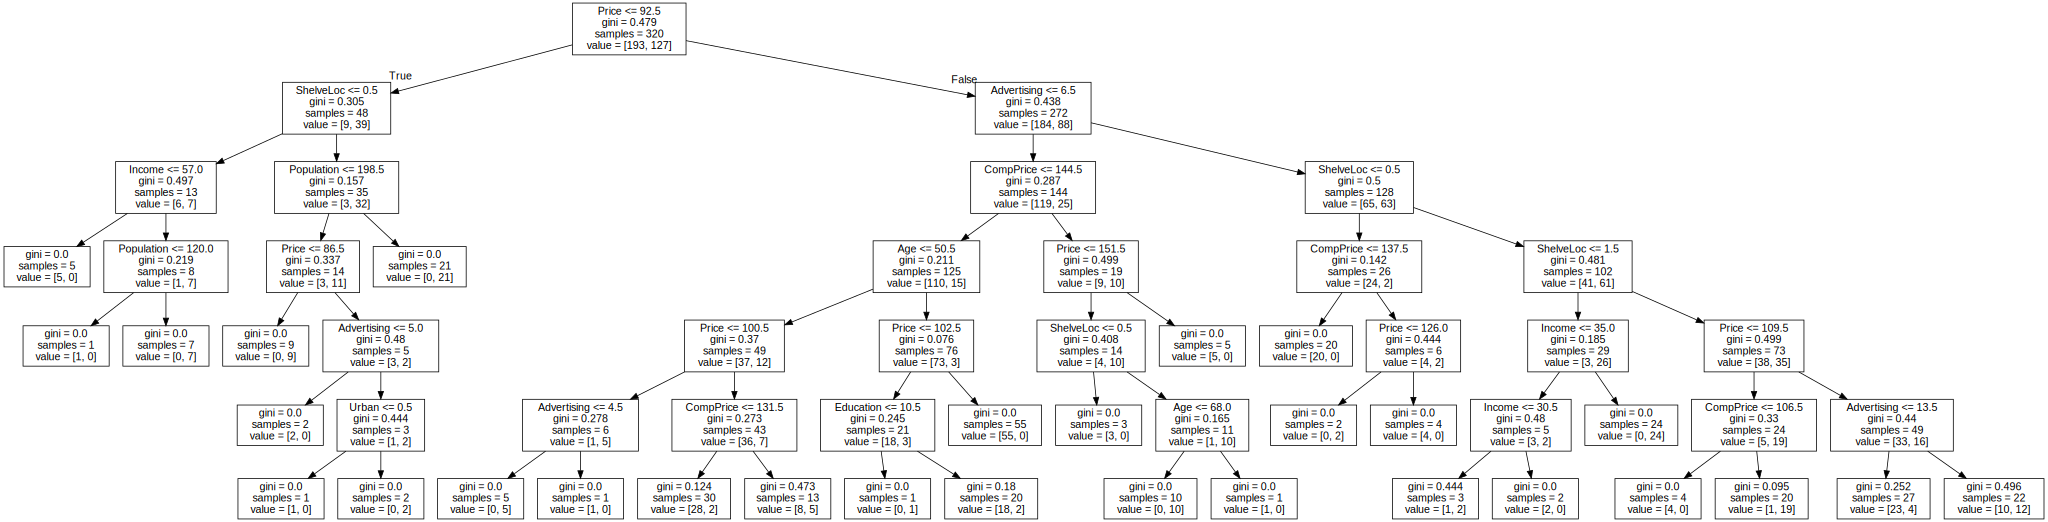

In [14]:
export_graphviz(classification_tree_carseats, out_file = "carseat_tree.dot", feature_names = X_train.columns)
with open("carseat_tree.dot") as f:   #This is the way we read the ".dot" file
    dot_graph = f.read()
graphviz.Source(dot_graph)

The most important indicator of `High` sales appears to be `Price` and then `ShelvLoc` and `Advertising`, because those are the first (strongest) branches in the tree. :-)

<b>(4)</b> To address the tree's performance on
the test data, we use the `predict()` function and build a confusion matrix. Note: Function <tt>confusion_matrix</tt> in <tt>sklearn.metrics</tt> implies each entry in $i$th row and $j$th column giving the number of samples with true label being $i$th class and predicted label being $j$th class. (If you want, you can transpose the matrix... be careful with the literature; each author chooses owns preference!:-)) Check https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [15]:
pred = classification_tree_carseats.predict(X_test) #Prediction for the X_test
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, #The "T" is just to transpose the confusion matrix
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)

     No  Yes
No   36   15
Yes   7   22


Testing accuracy is (36+22)/80 = 0.725, i.e. we are making correct predictions for
around 72.5% of the test data set. 

<b>How about precision, recall and specificity?</b> :-)

### 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree** to the `Boston` data set from the `MASS` library. This data set is about housing values and other information about Boston census tracts. Check <i>Introduction to Statistical Learning with Python</i>. Some of the variables are <tt>rmvar</tt> (average number of rooms per
house), <tt>age</tt> (proportion of owner-occupied units built prior to 1940), and
<tt>lstat</tt> (percent of households with low socioeconomic status). 

In [16]:
boston_df = pd.read_csv('Boston.csv')
boston_df.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


First, we create a training set, and fit the tree to the training data using `medv` (median home value) as our response.

In [17]:
#Prepare the chosen predictors (i.e. take "medv" variable out)
X = boston_df.drop(['Unnamed: 0','medv'], axis = 1)
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [18]:
#Create the "response variable"
y = boston_df.medv

In [19]:
#Split the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0) #Fix the random state (label=0)

In [20]:
# Choosing max depth 2
regr_tree_boston = DecisionTreeRegressor(max_depth = 2)
# 
regr_tree_boston.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

Let's take a look at the tree. Note that now (for a quantitative variable) we will consider the MSE (mean square error). For the other parameter check https://www.datacamp.com/tutorial/decision-tree-classification-python.

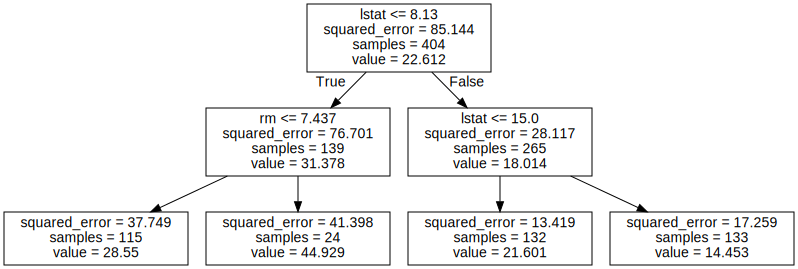

In [22]:
export_graphviz(regr_tree_boston, 
                out_file = "boston_tree.dot", 
                feature_names = X_train.columns)

with open("boston_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

The variable `lstat` measures the percentage of individuals with lower
socioeconomic status. The tree indicates that lower values of `lstat` correspond
to more expensive houses. The tree predicts a median house price
of \$45,766 for larger homes (`rm>=7.4351`) in suburbs in which residents have high socioeconomic
status (`lstat<7.81`).

Now let's see how it does on the test data:

Text(0, 0.5, 'y_test')

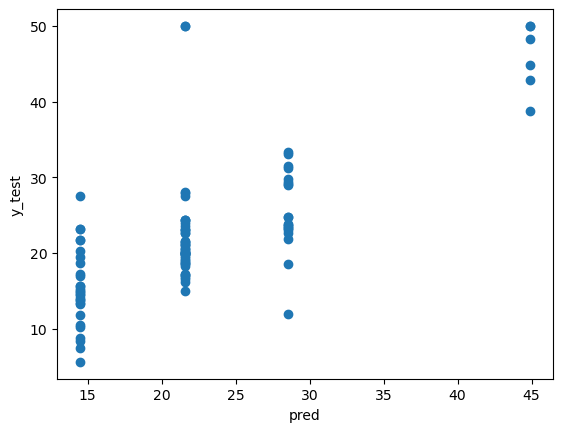

In [23]:
pred = regr_tree_boston.predict(X_test) #Use the tree to make a prediction to the test set of the predictors

plt.scatter(pred, 
            y_test, 
            label = 'medv')

#plt.plot([0, 1], 
#         [0, 1], 
#         '--k', 
#         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

Notice that the prediction of the home value are "discrete" values. Which is not the case of the real values. This is a common feature in tree-based methods for predicting quantitative variables.

Now we calculate the error of such predictions:

In [24]:
print(np.sqrt(mean_squared_error(y_test, pred)))

5.950312246327099


Conclusion: This model leads to test predictions that are within around \$5,950 of
the true median home value for the suburb. <b>Is this good or bad?</b>

### 8.3.3 Bagging and Random Forests

Let's see if we can improve on this result using **bagging** and **random forests**. The exact results obtained in this section may
depend on the version of `python` and the version of the `RandomForestRegressor` package
installed on your computer, so don't stress out if you don't match up exactly with the book. 

Recall that **bagging** is simply a special case of
a **random forest** with $m = p$, i.e. using all available predictors. 
Therefore, the `RandomForestRegressor()` function can
be used to perform both random forests and bagging. Check https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html.

Let's start with bagging:

In [25]:
# Bagging: using all features (#=13)
bagged_boston = RandomForestRegressor(max_features = 13, random_state = 1) #fixes another random state
bagged_boston.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

The argument `max_features = 13` indicates that all 13 predictors should be considered
for each split of the tree -- in other words, that bagging should be done. <b>How
well does this bagged model perform on the test set?</b> Answer:

Text(0, 0.5, 'y_test')

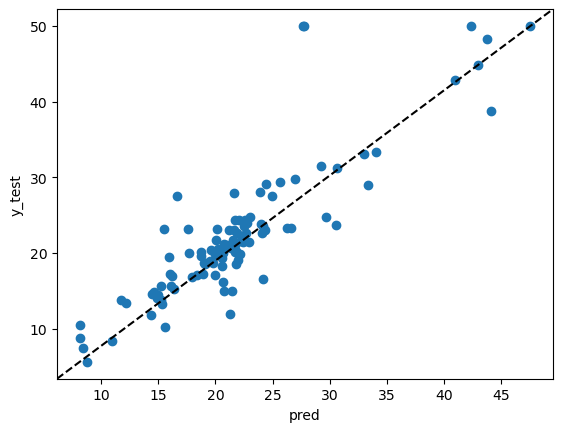

In [26]:
pred = bagged_boston.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv') 

plt.plot([0, 1], #Plot line Y_axis=x_axis (i.e. slope=1)
         [0, 1], 
         '--k',  #with dashed lines
         transform = plt.gca().transAxes) #Extends the dashed lines to entire graphic

plt.xlabel('pred')
plt.ylabel('y_test')

IMPORTANT OBSERVATION: Now (with bagging) with do not have the "discrete" predictions as we did above, with one single decision tree. <b>Why?</b> (recall what bagging is)

In [27]:
np.sqrt(mean_squared_error(y_test, pred))

4.4114594123780435

The test set MSE associated with the bagged regression tree is significantly lower than our single tree!

### Random forests (select a subset of predictors)

We can grow a random forest in exactly the same way, except that
we'll use a smaller value of the `max_features` argument. Here we'll
use `max_features = 6`:

In [28]:
# Random forests: using 6 features
random_forest_boston = RandomForestRegressor(max_features = 6, random_state = 1) #Same random state as for bagging

random_forest_boston.fit(X_train, y_train)

pred = random_forest_boston.predict(X_test)

## Error
np.sqrt(mean_squared_error(y_test, pred))

4.698943473240117

The test set MSE is slightly higher than for bagging <b>in this case</b>. 

### Assessing the importance of each predictor

Using the `feature_importances_` attribute of the `RandomForestRegressor`, we can view the importance of each variable.

<b>Note:</b> Definition of "importance" is given by the so-called "Gini Importance" or "Mean Decrease in Impurity" (MDI): sum over the number of splits across all trees that include the feature, weighted with the number of samples it splits. Always check the documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

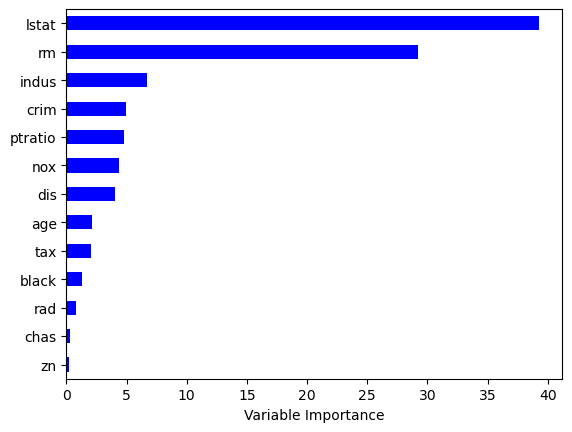

In [29]:
Importance = pd.DataFrame({'Importance':random_forest_boston.feature_importances_*100}, 
                          index = X.columns) 

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh',  #horizontal bars
                                              color = 'b', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

The results indicate that across all of the trees considered in the random
forest, the wealth level of the community (`lstat`) and the house size (`rm`)
are by far the two most important variables.

### 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree. Function `learning_rate` is the "speed" the algorithm is converging towards the optimal value (i.e. how much it "boosts" :-)). Note that: a very high learning rate is not necessarily better (try yourself). <b>Why?</b>

In [30]:
boosted_boston = GradientBoostingRegressor(n_estimators = 500, #Number of trees
                                           learning_rate = 0.01,  #lambda
                                           max_depth = 4, 
                                           random_state = 1)

boosted_boston.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

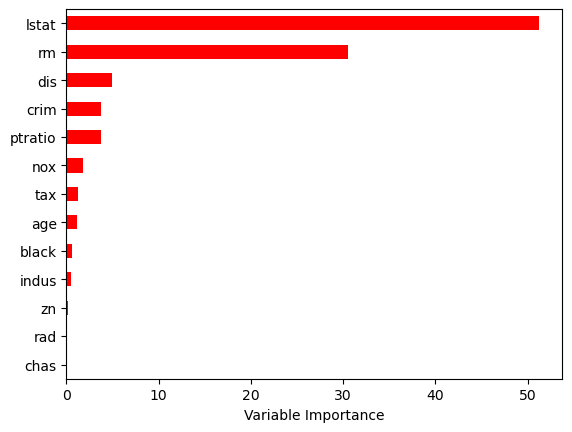

In [31]:
feature_importance = boosted_boston.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False)

rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [32]:
np.sqrt(mean_squared_error(y_test, boosted_boston.predict(X_test)))

4.364215595327804

The test MSE obtained is similar to the test MSE for random forests
and superior to that for bagging. If we want to, we can perform boosting
with a different value of the learning rate $\lambda$. Here we take $\lambda = 0.2$:

In [33]:
boosted_boston2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.2,  ##Different learning rate
                                            max_depth = 4, 
                                            random_state = 1)
boosted_boston2.fit(X_train, y_train)

np.sqrt(mean_squared_error(y_test, boosted_boston2.predict(X_test)))

4.203223400272277

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$. This is not always the case (try yourself). <b>Why?</b>